In [1]:
import os

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42
N_FOLDS = 5

In [3]:
np.random.seed(RANDOM_STATE) # задаем фиксированные начальные условия для генератора случайных чисел

# Чтение и скачивание данных 

Построим модель, которая будет предсказывать общую продолжительность поездок на такси в Нью-Йорке. 

Данные включает информацию о времени доставки, географических координатах, количествах пассажиров и др.

In [4]:
train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip', compression='zip')
test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip', compression='zip') 
train[:3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


* **id** - уникальный идентификатор для каждой поездки
***vendor_id** — код, указывающий поставщика, связанного с записью о поездке.
***pickup_datetime** - дата и время включения счетчика
***dropoff_datetime** - дата и время отключения счетчика
***passenger_count** - количество пассажиров в транспортном средстве (значение, введенное водителем)
***pickup_longitude** - долгота, где был задействован счетчик
***pickup_latitude** - широта, на которой был задействован счетчик
***dropoff_longitude** - долгота, где счетчик был отключен
***dropoff_latitude** — широта, на которой счетчик был отключен
***store_and_fwd_flag** — этот флаг указывает, хранилась ли запись о поездке в памяти транспортного средства перед отправкой продавцу, потому что у транспортного средства не было соединения с сервером — Y = сохранить и переслать; N = не промежуточная поездка
***trip_duration** - продолжительность поездки в секундах


In [5]:
# Добавим данные о погоде в 2016 году
weather = pd.read_csv("/kaggle/input/weather-data-in-new-york-city-2016/weather_data_nyc_centralpark_2016(1).csv")
weather[:3]

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


In [6]:
# Также добавим данные о маршрутах из OSRM
routes_1 = pd.read_csv('/kaggle/input/nyfastestroutes/fastest_routes_train_part_1.csv')
routes_2 = pd.read_csv('/kaggle/input/nyfastestroutes/fastest_routes_train_part_2.csv')
routes_1[:3]

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."


# Предварительная обработка данных

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Датасет не имеет пустых значений -> не нужна обработка пропусков.

In [8]:
train = train.drop_duplicates()
len(train)

1458644

Также отсутствуют дублирующиеся объекты.

In [9]:
# Cтатистика по каждому числовому признаку
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe() 
#test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


Обратим внимание на кол-во пассажиров - необходимо исключить поездки с 0 и 5-9 пассажирами. Также имеются вопросы к продолжительности   поездки (1 и 3526282 сек). И как уже было замечено, имеются долгота и широта не относящиеся к Нью-Йорку.

In [63]:
train_u = train['passenger_count'].unique()
print("Unique values for 'passenger_count' in train data", train_u )
test_u = test['passenger_count'].unique()
print("Unique values for 'passenger_count' in test data", test_u )

Unique values for 'passenger_count' in train data [1 4 2 3]
Unique values for 'passenger_count' in test data [1 2 4 5 3 6 0 9]


In [64]:
# Исключим данные, содержащие невозможные значения для кол-ва пассажиров
train = train[~train.passenger_count.isin([0, 5, 6, 7, 8, 9])]
test = test[~test.passenger_count.isin([0, 5, 6])]

In [12]:
# Исключим данные, содержащие невозможные значения для длительности поездки
train = train[train.trip_duration.between(120, 25200)]

## Анализ маршрутов train/test

(40.5, 41.0)

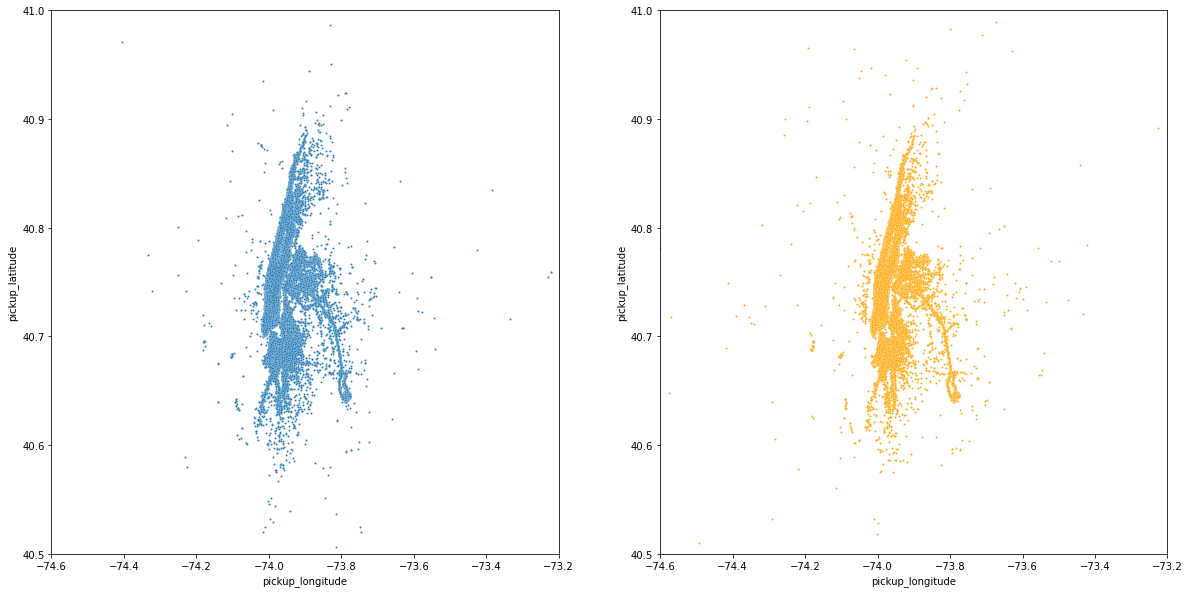

In [13]:
# Посмотрим на диаграммы рассеяния в тренировочных и тестовых данных
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.scatterplot(train['pickup_longitude'], train['pickup_latitude'], s=4, ax=ax[0])
ax[0].set_xlim([-74.6, -73.2])
ax[0].set_ylim([40.5, 41.0])

sns.scatterplot(test['pickup_longitude'],
                test['pickup_latitude'], s=4, ax=ax[1], color='orange')
ax[1].set_xlim([-74.6, -73.2])
ax[1].set_ylim([40.5, 41.0])

Географические координаты Нью-Йорка, США:
* Широта: 40°42′51″ с.ш.
* Долгота: 74°00′21″ з.д.

Заметим, что оба графика повторяют карту Нью-Йорка. И как уже было замечено, имеются поездки, за пределами города (предполагаемые выбросы). Избавимся от них.

In [65]:
# Исключим данные, не подходящие по территориальному признаку
train = train[train.pickup_longitude.between(-74.2, -73.6) & train.dropoff_longitude.between(-74.2, -73.6) & 
              train.pickup_latitude.between(40.55, 40.95) & train.dropoff_latitude.between(40.55, 40.95)]

test = test[test.pickup_longitude.between(-74.2, -73.6) & test.dropoff_longitude.between(-74.2, -73.6) & 
            test.pickup_latitude.between(40.55, 40.95) & test.dropoff_latitude.between(40.55, 40.95)]

## Feature engineering

1) Найдем расстояние в километрах haversine (от точки до точки по прямой с учетом формы Земли)

In [15]:
# Параллельные вычисления для быстроты работы
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
from math import radians, cos, sin, asin, sqrt

def haversine(data):
    # Вычисление расстояния в километрах между двумя точками на Земле
    lon1 = data['pickup_longitude']
    lat1 = data['pickup_latitude']
    lon2 = data['dropoff_longitude']
    lat2 = data['dropoff_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

In [17]:
# Добавляем новый признак в датасеты
train['distance_geo'] = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude']].parallel_apply(haversine, axis=1)

In [18]:
test['distance_geo'] = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                             'dropoff_latitude']].parallel_apply(haversine, axis=1)

In [19]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance_geo
count,1304131.000,1304131.000,1304131.000,1304131.000,1304131.000,1304131.000,1304131.000,1304131.000
mean,1.491,1.313,-73.974,40.751,-73.974,40.752,851.022,3.478
std,0.500,0.659,0.038,0.028,0.035,0.032,661.355,3.889
min,1.000,1.000,-74.195,40.551,-74.200,40.551,120.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,410.000,1.273
50%,1.000,1.000,-73.982,40.754,-73.980,40.754,673.000,2.134
75%,2.000,1.000,-73.968,40.768,-73.963,40.770,1083.000,3.929
max,2.000,4.000,-73.605,40.944,-73.601,40.950,24351.000,40.854


In [20]:
train[train.distance_geo < 0.01]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.982,40.769,-73.982,40.769,N,227,0.000
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959,40.776,-73.959,40.776,N,1109,0.000
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.787,40.647,-73.787,40.647,N,580,0.000
2087,id0931199,2,2016-05-04 22:28:43,2016-05-04 22:32:51,1,-73.955,40.777,-73.955,40.777,N,248,0.000
2710,id0111601,1,2016-02-02 00:48:37,2016-02-02 00:51:49,1,-73.945,40.752,-73.945,40.752,N,192,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,id0618137,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.979,40.757,-73.979,40.757,N,1284,0.000
1456627,id1048767,2,2016-02-06 22:01:40,2016-02-06 22:03:47,1,-73.964,40.769,-73.964,40.769,N,127,0.000
1456989,id2595295,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.985,40.728,-73.985,40.728,N,566,0.000
1457114,id0051314,2,2016-04-09 20:34:21,2016-04-09 20:44:53,1,-73.966,40.771,-73.966,40.771,N,632,0.000


In [21]:
# Удалим поездки с нулевым расстоянием
train = train[~train.distance_geo.isin([0])]

In [22]:
weather.describe(include='object')

,date,precipitation,snow fall,snow depth
count,366,366,366,366
unique,366,63,11,10
top,1-1-2016,0,0,0
freq,1,116,179,346


In [23]:
weather.precipitation.unique()

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [24]:
# Значения T заменим на ноль
weather.loc[weather['precipitation'] == 'T', 'precipitation'] = '0.00'
weather['precipitation'] = weather['precipitation'].astype(float)

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype(float)

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype(float)

In [25]:
# Добавим информацию о погоде в датасет
train['date'] = train.pickup_datetime.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
weather['date'] = weather.date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

train_all = pd.merge(train, weather, how='left', on='date')

In [26]:
train_all[:3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.499,2016-03-14,51,40,45.500,0.290,0.000,0.000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.806,2016-06-12,83,62,72.500,0.000,0.000,0.000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.385,2016-01-19,28,16,22.000,0.000,0.000,0.000


In [27]:
train_all.isna().sum() # Проверим есть ли пустые значения (NA)

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
distance_geo           0
date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

2) Преобразуем время в новые признаки, которые удобно будет в дальнейшем исследовать

In [28]:
train_all['pickup_datetime'] = pd.to_datetime(train_all['pickup_datetime'])

train_all['pickup_month'] = train_all['pickup_datetime'].apply(lambda x: x.month) # номер месяца
train_all['pickup_day'] = train_all['pickup_datetime'].apply(lambda x: x.day) # день месяца
train_all['pickup_dayofweek'] = train_all['pickup_datetime'].apply(lambda x: x.dayofweek) # день недели
train_all['pickup_hour'] = train_all['pickup_datetime'].apply(lambda x: x.hour) # час начала поездки
train_all['pickup_minute'] = train_all['pickup_datetime'].apply(lambda x: x.minute) # минута начала поездки
train_all['pickup_weekends'] = train_all['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0) # флаг выходного

train_all['store_and_fwd_flag'] = 1 * (train_all.store_and_fwd_flag.values == 'Y')

In [29]:
train_all.reset_index(drop=True, inplace=True)
train_all[:3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,average temperature,precipitation,snow fall,snow depth,pickup_month,pickup_day,pickup_dayofweek,pickup_hour,pickup_minute,pickup_weekends
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,...,45.500,0.290,0.000,0.000,3,14,0,17,24,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,...,72.500,0.000,0.000,0.000,6,12,6,0,43,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,...,22.000,0.000,0.000,0.000,1,19,1,11,35,0


3) Создадим признаки, отвечающие за праздничные дни

In [30]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

train_all['pickup_holiday'] = train_all['date'].isin(holidays)
train_all['pickup_holiday'] = train_all['pickup_holiday'].map(lambda x: 1 if x == True else 0)

train_all['pickup_near_holiday'] = train_all['date'].isin(holidays + timedelta(
    days=1)) | train_all['date'].isin(holidays - timedelta(days=1))
train_all['pickup_near_holiday'] = train_all['pickup_near_holiday'].map(lambda x: 1 if x == True else 0)

4) Добавим информацию о протяженности дорог

In [31]:
routes = routes_1.append(routes_2)
train_all = pd.merge(train_all, routes[['id', 'total_distance']], on='id', how='left')

Теперь посмотрим на распределение времени поездки

In [32]:
# Статистика 'trip_duration'
train_all.trip_duration.describe()

count   1300704.000
mean        851.374
std         661.585
min         120.000
25%         411.000
50%         673.000
75%        1084.000
max       24351.000
Name: trip_duration, dtype: float64

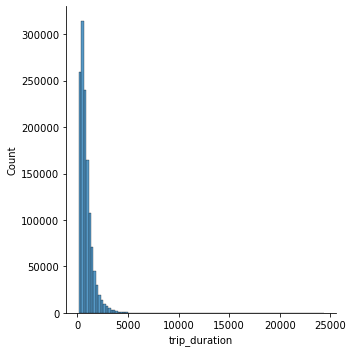

In [33]:
sns.displot(train_all.trip_duration, bins=100);

Видим, что есть выбросы - прологорифмируем целевую переменную и добавим значение в датасет

In [34]:
train_all = train_all.assign(log_trip_duration=np.log(train_all.trip_duration + 1))

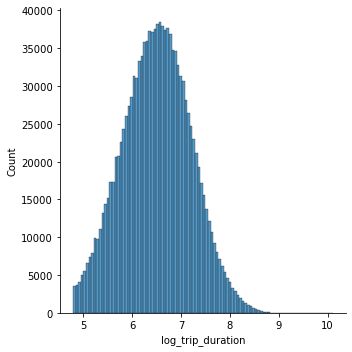

In [35]:
sns.displot(train_all.log_trip_duration, bins=100);

5) Переведем признаки в удобные единицы измерения и создадим параметр скорости

In [36]:
train_all['trip_duration_hour'] = train_all['trip_duration'] / 3600
train_all['total_distance_km'] = train_all['total_distance'] / 1000
train_all['speed_km_h'] = train_all['total_distance_km'] / train_all['trip_duration_hour']

## Обработка выбросов

In [37]:
train_all['speed_km_h'].describe()

count   1300704.000
mean         19.137
std           9.971
min           0.000
25%          12.467
50%          17.077
75%          23.327
max         783.684
Name: speed_km_h, dtype: float64

Видим явные выбросы, 0 и 12428.38286 - км/ч

In [38]:
# Исключим данные, содержащие невозможные значения для скорости поездки
train_all = train_all[train_all['speed_km_h'] > 2]
train_all = train_all[train_all['speed_km_h'] < 100] 

<function matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)>

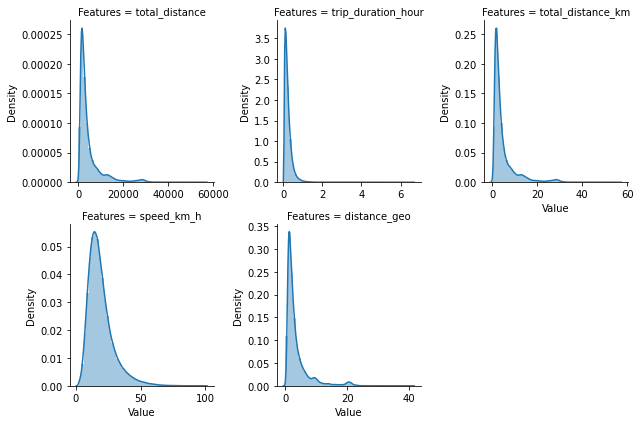

In [39]:
# Посмотрим на распределния других числовых признаков
num_cols = ['total_distance', 'trip_duration_hour',
            'total_distance_km', 'speed_km_h', 'distance_geo']

numeric_features = train_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                   col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust

In [40]:
for i in num_cols:
    train_all['log_'+i] = np.log(train_all[i]+1) # Прологарифмируем

<function matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)>

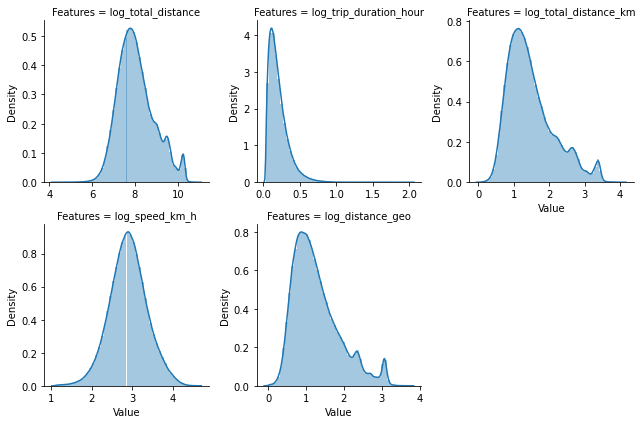

In [41]:
num_cols = ['log_total_distance', 'log_trip_duration_hour', 'log_total_distance_km',
    'log_speed_km_h', 'log_distance_geo']

numeric_features = train_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                   col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust

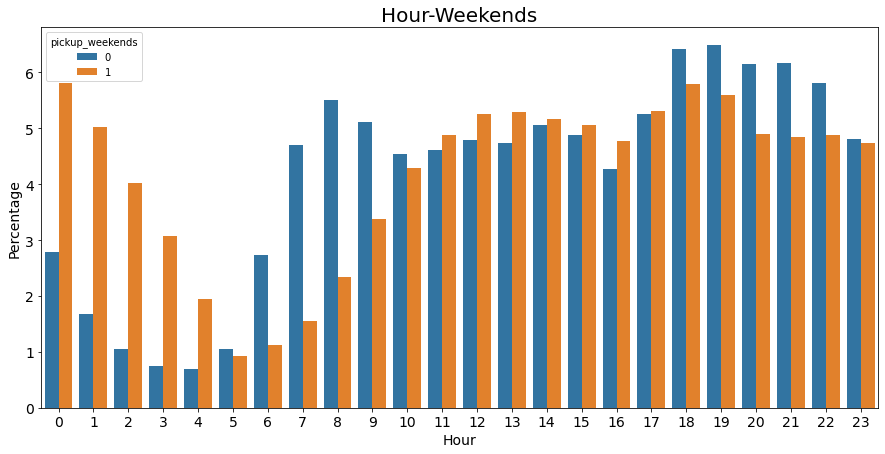

In [42]:
# Проанализируем какой процент поездок был в выходные и будние дни
norm_hours = (train_all.groupby(['pickup_weekends'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax = sns.barplot(x="pickup_hour", y="percentage", hue="pickup_weekends", data=norm_hours)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Можем заметить, что ночные поездки актуальнее в выходные дни, а утренние - в будние.

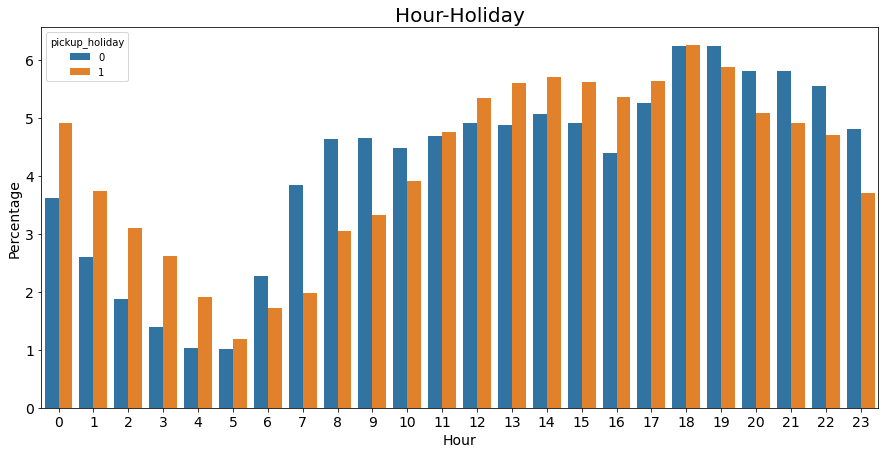

In [43]:
# То же самое статистика для праздничных и обычных дней
norm_hours = (train_all.groupby(['pickup_holiday'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax = sns.barplot(x="pickup_hour", y="percentage", hue="pickup_holiday", data=norm_hours)

plt.title('Hour-Holiday', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Ночные поездки актуальнее в праздничные дни, а утренние - в обычные.

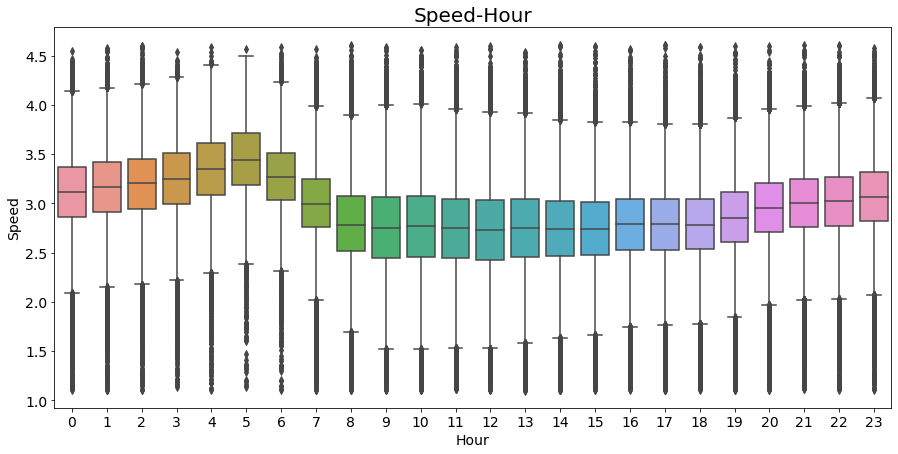

In [44]:
# Посмотрим на зависимость скорости от часа
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_speed_km_h', data=train_all)

plt.title('Speed-Hour', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Заметим, что скорость значительно увеличивается в период поздней ночи - раннего утра.

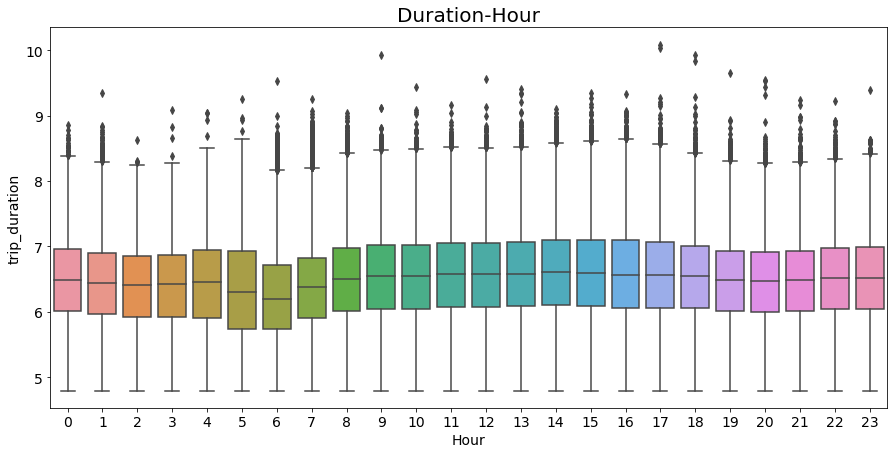

In [45]:
# Посмотрим на зависимость длительности поездки от часа
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_trip_duration', data=train_all)

plt.title('Duration-Hour', fontsize=20)
plt.ylabel('trip_duration', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Тут всё более равномерно. Визуально значимой зависимости не наблюдается.

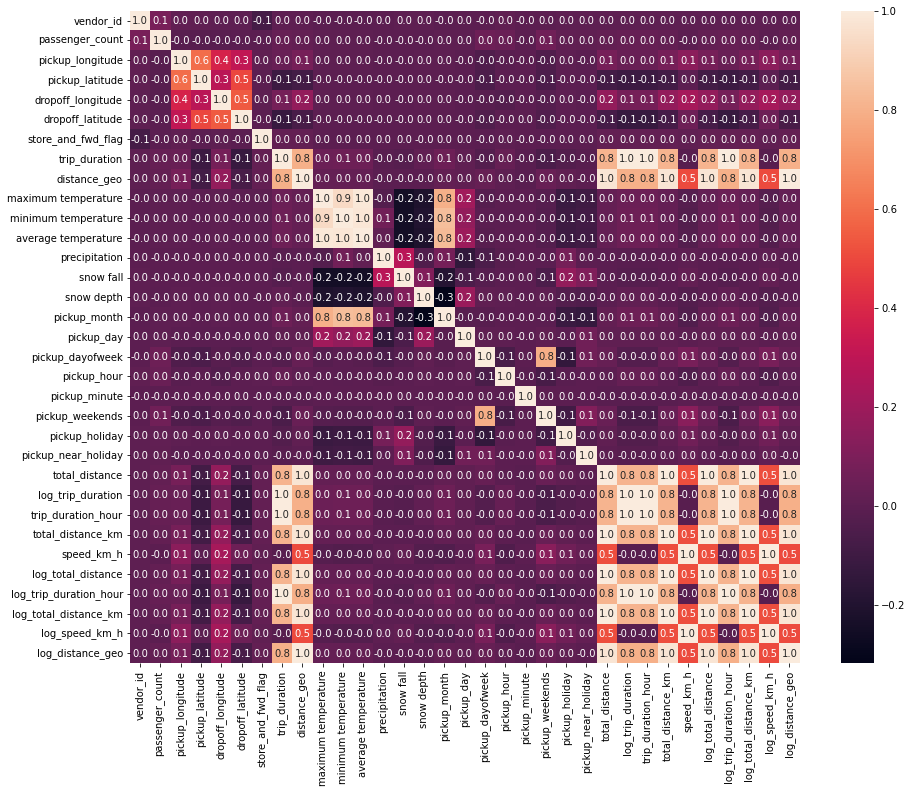

In [46]:
# Корреляционная матрица
plt.figure(figsize=(15, 12))

sns.heatmap(train_all.corr(method='spearman'), annot=True, fmt=".1f");

# Modeling

## LGBMRegressor + Optuna

In [47]:
import lightgbm as lg

import optuna

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

**Optuna** – фреймворк подбора оптимальных гиперпараметров, который использует байесовский подход 
для автоматизации пространства поиска гиперпараметров.

In [48]:
# Ненужные признаки
drop_cols_train = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_geo',
    
    'date',
    'total_distance',
    'total_distance_km',
    'log_total_distance_km',
    
    'trip_duration',
    'log_trip_duration',
    'trip_duration_hour',
    'log_trip_duration_hour',
    
    'speed_km_h',
    'log_speed_km_h',
]

Разделим выборку на тренировочную и тестовую:

In [49]:
X = train_all.drop(columns=drop_cols_train, axis=1)
y = train_all[['log_trip_duration']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE) #  умное разбиение данных

In [50]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [51]:
# Целевая функция
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 10, step=2),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200, step=10)
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE) # Кросс-валидация

    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l2")
        
        model = lg.LGBMRegressor(objective="regression", **param_grid)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="rmsle",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=-1)
        preds = model.predict(X_test)        
        cv_predicts[idx] = rmsle(y_test, preds)

    return np.mean(cv_predicts)

**callbacks** - класс обратного вызова, может обнаруживать бесперспективные наборы гиперпараметров перед обучением, тем самым значительно сокращая время поиска.

In [52]:
# Вычисляем ошибку
study = optuna.create_study(direction="minimize", study_name="LGB")
func = lambda trial: objective(trial, X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=2, show_progress_bar=True)

[I 2023-01-28 07:08:57,199] A new study created in memory with name: LGB


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2023-01-28 07:10:37,780] Trial 0 finished with value: 0.0464629959693887 and parameters: {'n_estimators': 1000, 'learning_rate': 0.28968234597920905, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 25}. Best is trial 0 with value: 0.0464629959693887.
[I 2023-01-28 07:13:02,538] Trial 1 finished with value: 0.04640940637149528 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18233870495401056, 'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 25}. Best is trial 1 with value: 0.04640940637149528.


In [53]:
# Выводим подобранные гиперпараметры
print(f"\tBest value (rmsle): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmsle): 0.04641
	Best params:
		n_estimators: 1000
		learning_rate: 0.18233870495401056
		num_leaves: 50
		max_depth: 5
		min_child_samples: 25


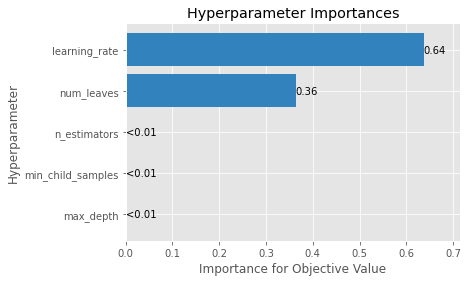

In [54]:
# Важность параметров
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

Обучим модель с новыми найденными параметрами:

In [55]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

finish_test_preds = []
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = lg.LGBMRegressor(objective="regression", **study.best_params)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="rmsle",
              early_stopping_rounds=100,
              verbose=-1)
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    
    print(f"id = {idx}", cv_predicts[idx], '\n')

print(np.mean(cv_predicts))

id = 0 0.33855336049809953 

id = 1 0.3406534743104213 

id = 2 0.33959365610321607 

id = 3 0.3394056519053114 

id = 4 0.34022431329399755 

0.33968609122220916


In [56]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred_exp = np.exp(test_pred.data) - 1 # потенцируем результат (т.к. до этого логарифмировали)

y_test_exp = np.exp(y_test.values) - 1 

In [57]:
print(f"OOF score: {np.mean(cv_predicts)}")
print(f"HOLDOUT score: {rmsle(y_test_exp, test_pred_exp)}")

OOF score: 0.33968609122220916
HOLDOUT score: 0.33899531331883015


# Feature importance

In [58]:
from sklearn.inspection import permutation_importance

In [59]:
r = permutation_importance(model, X_test, y_test, n_repeats=2)

In [60]:
perm_train = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()), index=('Score', 'Features'))
perm_train = perm_train.T
perm_train = perm_train.sort_values(ascending=False, by='Score')

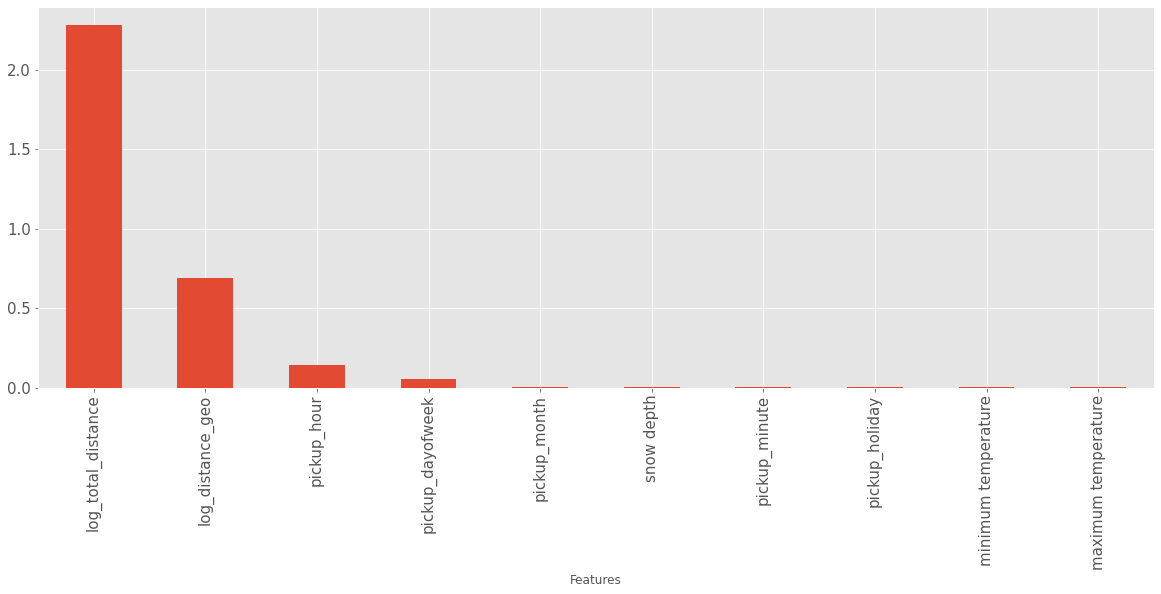

In [61]:
perm_train[:10].set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Submission

In [62]:
# submit_data = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip', compression='zip')
# submit_data

# submit_data['trip_duration'] = y_test_exp
# submit_data

# submit_data.to_csv('submission.csv', index=False)